In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import astropy.units as u
import astropy.coordinates as coord

import gala.coordinates as gc
import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.dynamics.nbody import DirectNBody
from gala.units import galactic, UnitSystem

import pandas as pd

import h5py

#Reading GD1 data
df_desi = pd.read_csv('/Users/bsegovia/Downloads/brigette_code/GD-1/GD-1/All_table_at_fig4b_cleaned_copy.csv')


In [2]:
def perturber_w0_calculation(p_mass):
    for mass_of_interest in p_mass: 
        # Defining constants 
        c_o = 19.9 
        a = [-0.195, 0.089, 0.089]
        b = -0.54
        x_sub = 1
        rho_c = 8.5 * 10**(-27) * (u.kg/u.m**3) # kg/m^3
        h = 0.7 # Normalized Hubble parameter 
        m_200 = mass_of_interest * u.Msun # Perturber masses
        r_200 = (m_200 * (3 / (4 * np.pi)) * (1 / rho_c))**(1 / 3)

        # Calculating c_200 
        term = 0 
        for i in range(len(a)):
            term += (a[i] * np.log(m_200 / (1e8 * h * u.Msun)))**i
        c_200 = c_o * (1 + term) * (1 + b * np.log(x_sub))

        # Calculating radius of the perturber
        r_s = r_200 / c_200

        ############################################################
        # Define parameters for the Hernquist potential (perturber)
        perturber_mass = m_200 # This value should be the same as m_200 used for v_escape calculation
        r = r_s.to(u.pc)  # Ensure units compatible with the potential's normalization
        pert_pot_for_vesc = gp.HernquistPotential(m=perturber_mass, c=r_s.to(u.kpc), units=galactic) # Initialize Hernquist potential

        # Convert position to galactic units (normalize by galactic scale)
        r_dimensionless = (r / galactic['length']).decompose() 
        potential_at_r = pert_pot_for_vesc.energy([r_dimensionless, 0, 0]) # Potential energy at radius r

        # Ensure potential_at_r is in specific energy units (e.g., km²/s²)
        potential_at_r = potential_at_r.to(u.km**2 / u.s**2)

        # Calculate escape velocity using v_esc = sqrt(-2 * Phi(r))
        v_esc = np.sqrt(-2 * potential_at_r)

        # Output escape velocity (in km/s)
        print(f"Escape velocity at r = {r}: {v_esc.to(u.km/u.s)}")

        # Calculate perturber phase space based on new escape velocity
        v_esc = v_esc.to(u.km/u.s)  # Ensure v_esc is in km/s
        d_vel = v_esc[0].value/2
        
        perturber_w0_dx = gd.PhaseSpacePosition(pos=[-4.41,13.00,9.58]*u.kpc,
                           vel=[-200.4-d_vel ,-162.6,13.9]*u.km/u.s)
        
        perturber_w0_dy = gd.PhaseSpacePosition(pos=[-4.41, 13.00, 9.58] * u.kpc,
                            vel=[-200.4 ,-162.6-d_vel,13.9]*u.km/u.s)
        
        perturber_w0_dz = gd.PhaseSpacePosition(pos=[-4.41, 13.00, 9.58] * u.kpc,
                            vel=[-200.4 ,-162.6,13.9-d_vel]*u.km/u.s)
    
    return r_s, perturber_w0_dx, perturber_w0_dy, perturber_w0_dz



In [3]:
p_mass = [1e6, 5e6, 1e7, 5e7, 1e8, 5e8] #perturber masses
r_s, perturber_w0_dx, perturber_w0_dy, perturber_w0_dz = perturber_w0_calculation(p_mass)


Escape velocity at r = 352.7117847465658 pc: [3.49197044] km / s
Escape velocity at r = 584.7610346486892 pc: [6.06423934] km / s
Escape velocity at r = 722.26346645077 pc: [7.71671961] km / s
Escape velocity at r = 1163.5277237253897 pc: [13.59493635] km / s
Escape velocity at r = 1421.3842273807156 pc: [17.39501463] km / s
Escape velocity at r = 2240.053567121574 pc: [30.98391871] km / s


In [4]:
def stream(perturber_mass_list):
    '''This function takes in a list of perturber masses and returns two lists, stream and progenitor.
       Each of these two lists contain the information output according to the input progenitor mass.
       The list should only contain values and no units.'''

    stream = [] #here we store the stream info
    progenitor = [] #here we store the progenitor info
    perturber = [] #here we store the perturber info

    df = ms.ChenStreamDF()#This is the stream data frame (BILLS)

    # pot = gp.BovyMWPotential2014(units=galactic) #This is the potential for the galaxy. 
    pot = gp.CCompositePotential()
    pot['hernquist'] = gp.HernquistPotential(m=0.6E10*u.Msun, c=0.7*u.kpc, units=galactic)
    pot['MNdisk'] = gp.MiyamotoNagaiPotential(m=5E10*u.Msun, a=3*u.kpc, b=0.26*u.kpc, units=galactic)
    pot['LSNFW'] = gp.LeeSutoTriaxialNFWPotential(v_c=220.*u.km/u.s, r_s=20.*u.kpc, a=1, b=1., c=0.87, units=galactic)
    static_frame = gp.StaticFrame(galactic) #the MW is is in a static frame 
    H = gp.Hamiltonian(potential=pot, frame=static_frame) #Used for Ms.MockStreamGenerator

    # Define progenitor information 
    # Gaia coordinates of GD1 core IC in Standard Galactic Cartesian coordinates (from Koposov et al 2010):
    prog_w0 = gd.PhaseSpacePosition(pos=[-3.41,13.00,9.58]*u.kpc,
                            vel=[-200.4,-162.6,13.9]*u.km/u.s)
    prog_mass = 1e5 * u.Msun #shouldnt change

    ############################################################

    # return output_dict
    output_dict_dx = {}
    output_dict_dy = {}
    output_dict_dz = {}

    for p_mass in perturber_mass_list:
        perturber_mass = p_mass * u.Msun

        r_s, perturber_w0_dx, perturber_w0_dy, perturber_w0_dz = perturber_w0_calculation(perturber_mass_list)

        # Define the combined initial conditions for dx
        w0_combined_dx = gd.combine((prog_w0, perturber_w0_dx))
        # Define the combined initial conditions for dy
        w0_combined_dy = gd.combine((prog_w0, perturber_w0_dy))
        # Define the combined initial conditions for dz
        w0_combined_dz = gd.combine((prog_w0, perturber_w0_dz))

        # Potentials
        prog_pot = gp.PlummerPotential(m=prog_mass, b=4*u.pc, units=galactic)
        perturber_pot = gp.HernquistPotential(m=perturber_mass, c=r_s.to(u.pc), units=galactic)

        tot_pot = [prog_pot, perturber_pot]

        perturber_dx = gd.DirectNBody(perturber_w0_dx, [perturber_pot], external_potential=pot)
        perturber_dy = gd.DirectNBody(perturber_w0_dy, [perturber_pot], external_potential=pot)
        perturber_dz = gd.DirectNBody(perturber_w0_dz, [perturber_pot], external_potential=pot)

        # Generate the stream for dx
        gen_dx = ms.MockStreamGenerator(df, H, progenitor_potential=prog_pot)
        output_filename_dx = f'snapshot_files/snapshots_dx_{p_mass}'
        stream_dx, prog_dx = gen_dx.run(prog_w0=prog_w0, prog_mass=prog_mass, nbody=perturber_dx, release_every=1, n_particles=1,
                                        #output_every=True, output_filename=output_filename_dx, check_filesize=True,
                                        overwrite=True, progress=False, dt=-1*u.Myr, n_steps=5000)# dt=-2*u.Myr, n_steps=1500)

        output_dict_dx[p_mass] = (stream_dx, prog_dx[0], prog_dx[1])

        # Generate the stream for dy
        gen_dy = ms.MockStreamGenerator(df, H, progenitor_potential=prog_pot)
        output_filename_dy = f'snapshot_files/snapshots_dy_{p_mass}'
        stream_dy, prog_dy = gen_dy.run(prog_w0=prog_w0, prog_mass=prog_mass, nbody=perturber_dy, release_every=1, n_particles=1,
                                        #output_every=True, output_filename=output_filename_dy, check_filesize=True,
                                        overwrite=True, progress=False, dt=-1*u.Myr, n_steps=5000)# dt=-2*u.Myr, n_steps=1500)

        output_dict_dy[p_mass] = (stream_dy, prog_dy[0], prog_dy[1])

        # Generate the stream for dz
        gen_dz = ms.MockStreamGenerator(df, H, progenitor_potential=prog_pot)
        output_filename_dz = f'snapshot_files/snapshots_dz_{p_mass}'
        stream_dz, prog_dz = gen_dz.run(prog_w0=prog_w0, prog_mass=prog_mass, nbody=perturber_dz, release_every=1, n_particles=1,
                                        #output_every=True, output_filename=output_filename_dz, check_filesize=True,
                                        overwrite=True, progress=False, dt=-1*u.Myr, n_steps=5000)# dt=-2*u.Myr, n_steps=1500)
                                        

        output_dict_dz[p_mass] = (stream_dz, prog_dz[0], prog_dz[1])

    return output_dict_dx, output_dict_dy, output_dict_dz

In [5]:
p_mass = [1e6, 5e6, 1e7, 5e7, 1e8, 5e8] #perturber masses
stream_data, stream_data_dy, stream_data_dz = stream(p_mass) #stream data

Escape velocity at r = 352.7117847465658 pc: [3.49197044] km / s
Escape velocity at r = 584.7610346486892 pc: [6.06423934] km / s
Escape velocity at r = 722.26346645077 pc: [7.71671961] km / s
Escape velocity at r = 1163.5277237253897 pc: [13.59493635] km / s
Escape velocity at r = 1421.3842273807156 pc: [17.39501463] km / s
Escape velocity at r = 2240.053567121574 pc: [30.98391871] km / s
Escape velocity at r = 352.7117847465658 pc: [3.49197044] km / s
Escape velocity at r = 584.7610346486892 pc: [6.06423934] km / s
Escape velocity at r = 722.26346645077 pc: [7.71671961] km / s
Escape velocity at r = 1163.5277237253897 pc: [13.59493635] km / s
Escape velocity at r = 1421.3842273807156 pc: [17.39501463] km / s
Escape velocity at r = 2240.053567121574 pc: [30.98391871] km / s
Escape velocity at r = 352.7117847465658 pc: [3.49197044] km / s
Escape velocity at r = 584.7610346486892 pc: [6.06423934] km / s
Escape velocity at r = 722.26346645077 pc: [7.71671961] km / s
Escape velocity at r 

<>:19: SyntaxWarning: invalid escape sequence '\D'
<>:21: SyntaxWarning: invalid escape sequence '\o'
<>:31: SyntaxWarning: invalid escape sequence '\D'
<>:33: SyntaxWarning: invalid escape sequence '\o'
<>:43: SyntaxWarning: invalid escape sequence '\D'
<>:45: SyntaxWarning: invalid escape sequence '\o'
<>:19: SyntaxWarning: invalid escape sequence '\D'
<>:21: SyntaxWarning: invalid escape sequence '\o'
<>:31: SyntaxWarning: invalid escape sequence '\D'
<>:33: SyntaxWarning: invalid escape sequence '\o'
<>:43: SyntaxWarning: invalid escape sequence '\D'
<>:45: SyntaxWarning: invalid escape sequence '\o'
/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/T/ipykernel_41623/3010057115.py:19: SyntaxWarning: invalid escape sequence '\D'
  axs[i, 0].scatter(perturber_x.pos.x.value, perturber_x.pos.y.value, color='black', s=15, alpha=1, label='DM Subhalo $\Delta V_{esc, x}$')
/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/T/ipykernel_41623/3010057115.py:21: SyntaxWarning: invalid escape sequence

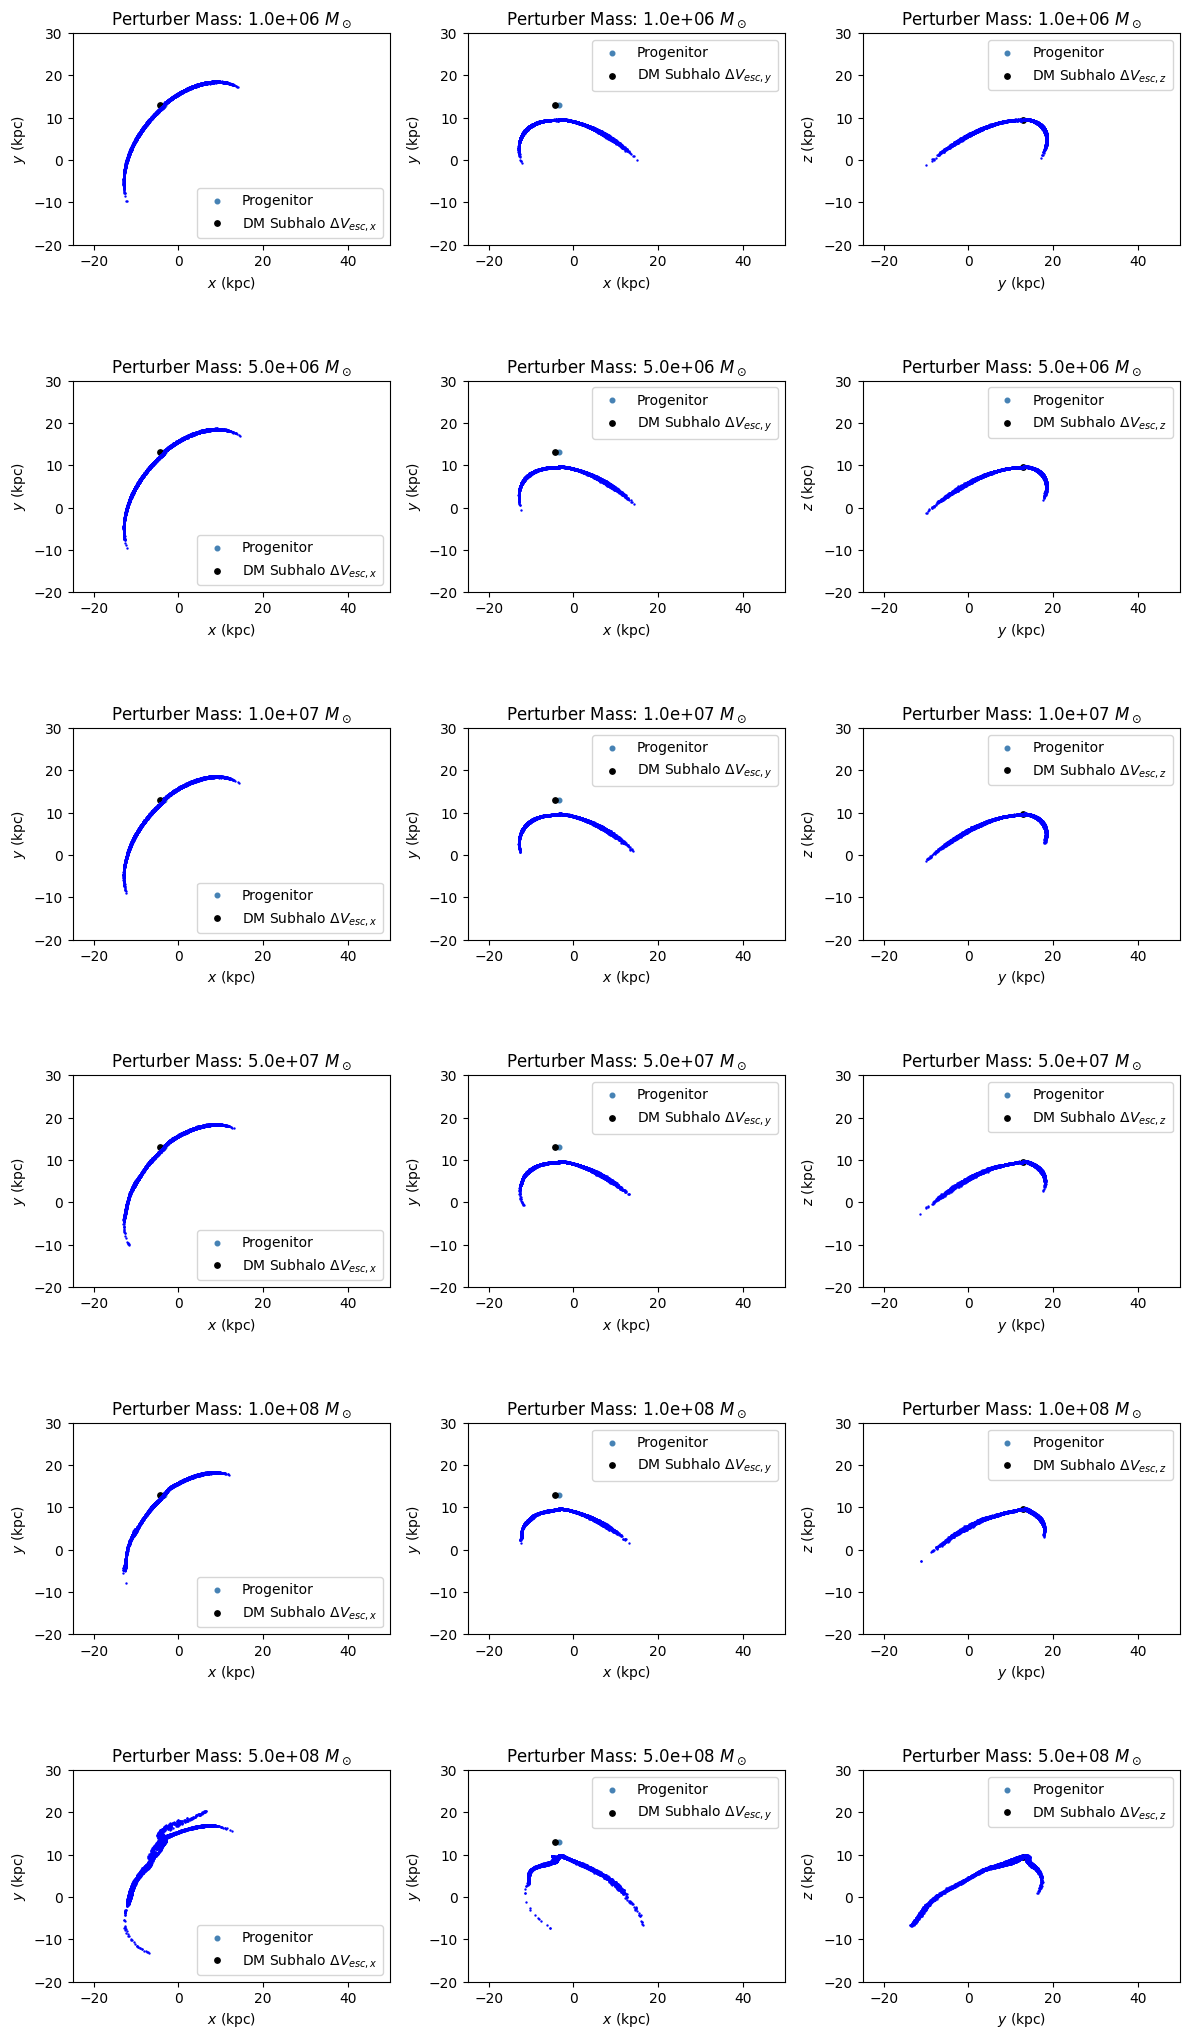

In [6]:
fig, axs = plt.subplots(len(p_mass), 3, figsize=(12, 3.5 * len(p_mass)))

for i, pert_mass in enumerate(p_mass):
    # Retrieve the stream and progenitor information from output_dict
    stream_x = stream_data[pert_mass][0]
    prog_x = stream_data[pert_mass][1]
    perturber_x = stream_data[pert_mass][2]

    stream_y = stream_data_dy[pert_mass][0]
    prog_y = stream_data_dy[pert_mass][1]
    perturber_y = stream_data_dy[pert_mass][2]

    stream_z = stream_data_dz[pert_mass][0]
    prog_z = stream_data_dz[pert_mass][1]
    perturber_z = stream_data_dz[pert_mass][2]

    # Plot the progenitor and DM subhalo for x vs y
    axs[i, 0].scatter(prog_x.pos.x.value, prog_x.pos.y.value, color='steelblue', s=11, alpha=1, label= 'Progenitor')
    axs[i, 0].scatter(perturber_x.pos.x.value, perturber_x.pos.y.value, color='black', s=15, alpha=1, label='DM Subhalo $\Delta V_{esc, x}$')
    axs[i, 0].scatter(stream_x.pos.x.value, stream_x.pos.y.value, c='blue', s=0.5, alpha=1)
    axs[i, 0].set_title(f'Perturber Mass: {pert_mass:.1e} $M_\odot$')
    axs[i, 0].set_xlabel(r'$x\ ({\rm kpc})$')
    axs[i, 0].set_ylabel(r'$y\ ({\rm kpc})$')
    axs[i, 0].set_xlim(-25, 50)
    axs[i, 0].set_ylim(-20, 30)
    axs[i, 0].legend(loc='best')
    axs[i, 0].set_aspect(1)

    # Plot the progenitor and DM subhalo for x vs z
    axs[i, 1].scatter(prog_y.pos.x.value, prog_y.pos.y.value, color='steelblue', s=11, alpha=1, label= 'Progenitor')
    axs[i, 1].scatter(perturber_y.pos.x.value, perturber_y.pos.y.value, color='black', s=15, alpha=1, label='DM Subhalo $\Delta V_{esc, y}$')
    axs[i, 1].scatter(stream_y.pos.x.value, stream_y.pos.z.value, c='blue', s=0.5, alpha=1)
    axs[i, 1].set_title(f'Perturber Mass: {pert_mass:.1e} $M_\odot$')
    axs[i, 1].set_xlabel(r'$x\ ({\rm kpc})$')
    axs[i, 1].set_ylabel(r'$y\ ({\rm kpc})$')
    axs[i, 1].set_xlim(-25, 50)
    axs[i, 1].set_ylim(-20, 30)
    axs[i, 1].legend(loc='best')
    axs[i, 1].set_aspect(1)

    # Plot the progenitor and DM subhalo for y vs z
    axs[i, 2].scatter(prog_z.pos.y.value, prog_z.pos.z.value, color='steelblue', s=11, alpha=1, label= 'Progenitor')
    axs[i, 2].scatter(perturber_z.pos.y.value, perturber_z.pos.z.value, color='black', s=15, alpha=1, label='DM Subhalo $\Delta V_{esc, z}$')
    axs[i, 2].scatter(stream_z.pos.y.value, stream_z.pos.z.value, c='blue', s=0.5, alpha=1)
    axs[i, 2].set_title(f'Perturber Mass: {pert_mass:.1e} $M_\odot$')
    axs[i, 2].set_xlabel(r'$y\ ({\rm kpc})$')
    axs[i, 2].set_ylabel(r'$z\ ({\rm kpc})$')
    axs[i, 2].set_xlim(-25, 50)
    axs[i, 2].set_ylim(-20, 30)
    axs[i, 2].legend(loc='best')
    axs[i, 2].set_aspect(1)

plt.savefig('stream_plots.png', dpi = 400)
plt.tight_layout()
plt.show()

<>:34: SyntaxWarning: invalid escape sequence '\D'
<>:35: SyntaxWarning: invalid escape sequence '\o'
<>:51: SyntaxWarning: invalid escape sequence '\D'
<>:52: SyntaxWarning: invalid escape sequence '\o'
<>:68: SyntaxWarning: invalid escape sequence '\D'
<>:69: SyntaxWarning: invalid escape sequence '\o'
<>:34: SyntaxWarning: invalid escape sequence '\D'
<>:35: SyntaxWarning: invalid escape sequence '\o'
<>:51: SyntaxWarning: invalid escape sequence '\D'
<>:52: SyntaxWarning: invalid escape sequence '\o'
<>:68: SyntaxWarning: invalid escape sequence '\D'
<>:69: SyntaxWarning: invalid escape sequence '\o'
/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/T/ipykernel_41623/2594223558.py:34: SyntaxWarning: invalid escape sequence '\D'
  axs[i, 0].scatter(perturber_x.pos.x.value, perturber_x.pos.y.value, color='orange', marker = '*', s=50, alpha=1, label='DM Subhalo $\Delta V_{esc, x}$')
/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/T/ipykernel_41623/2594223558.py:35: SyntaxWarning: invalid 

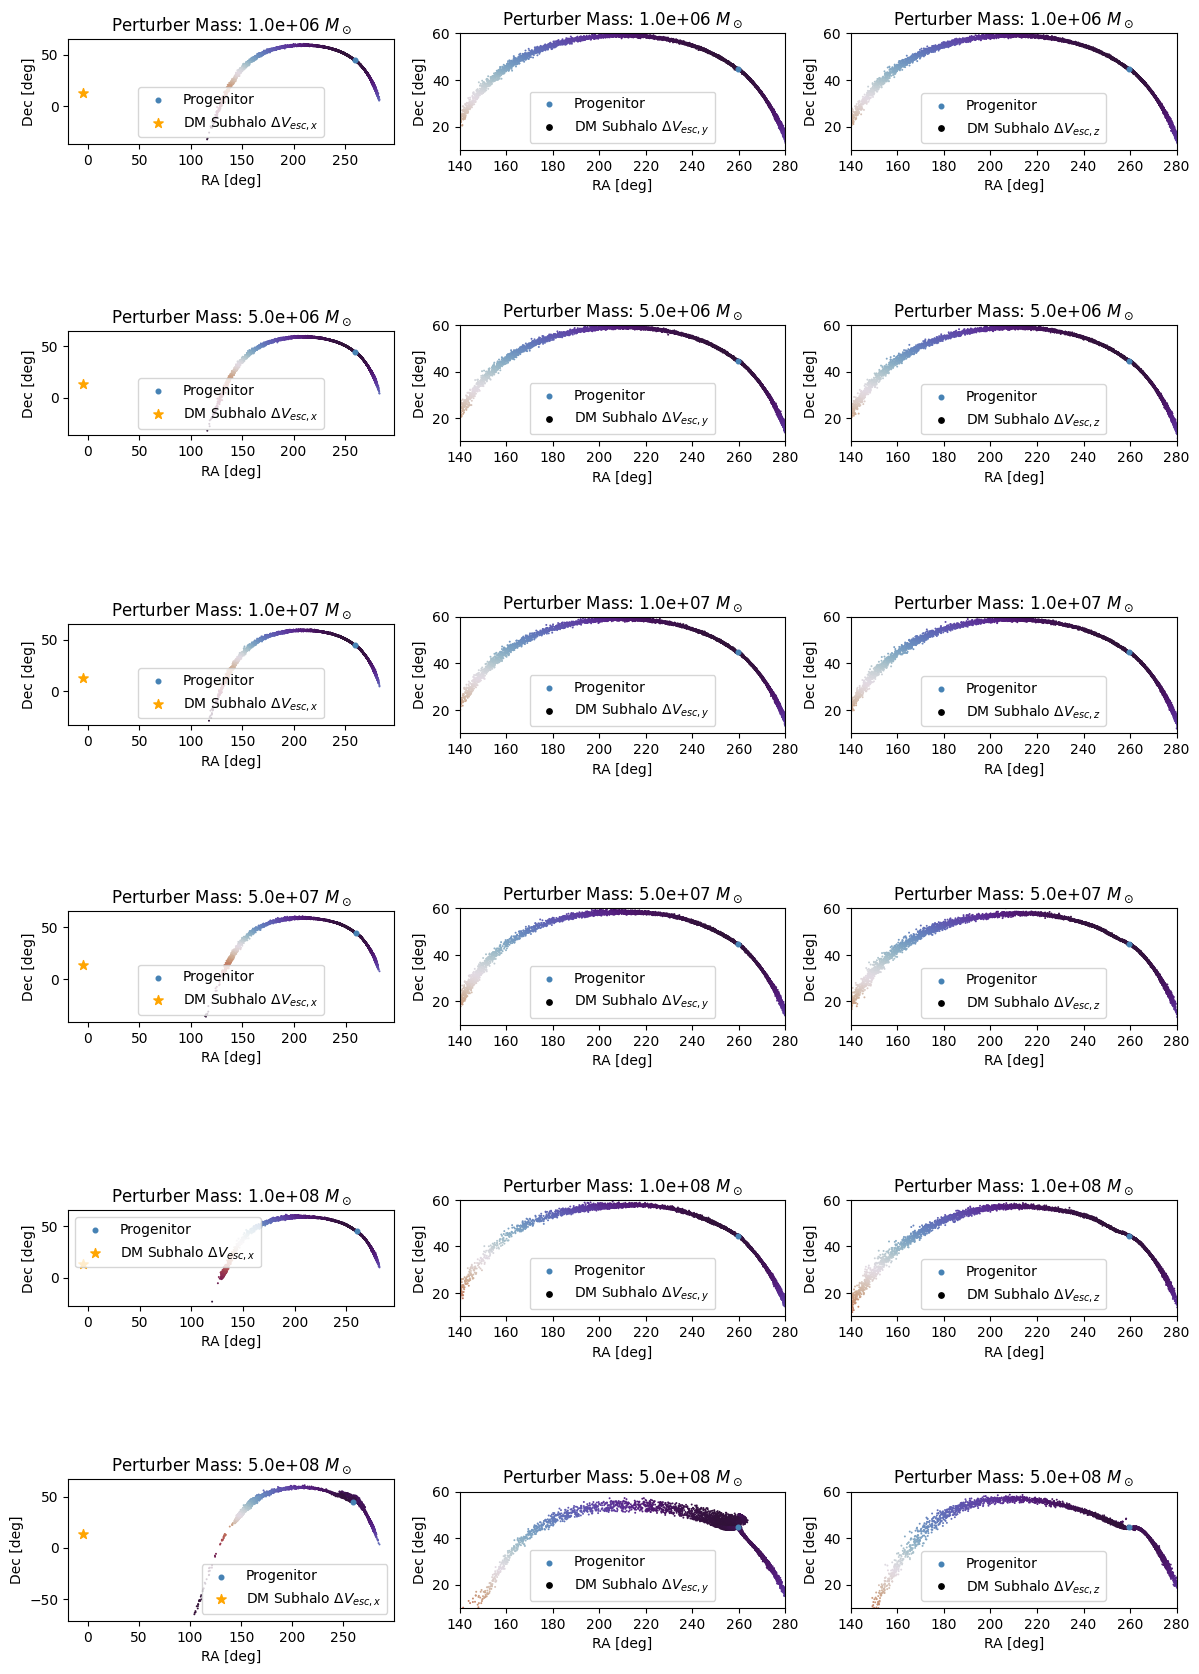

In [7]:
fig, axs = plt.subplots(len(p_mass), 3, figsize=(12, 3 * len(p_mass)))

for i, pert_mass in enumerate(p_mass):
    # Retrieve the stream and progenitor information from output_dict
    stream_x = stream_data[pert_mass][0]
    prog_x = stream_data[pert_mass][1]
    perturber_x = stream_data[pert_mass][2]

    stream_y = stream_data_dy[pert_mass][0]
    prog_y = stream_data_dy[pert_mass][1]
    perturber_y = stream_data_dy[pert_mass][2]

    stream_z = stream_data_dz[pert_mass][0]
    prog_z = stream_data_dz[pert_mass][1]
    perturber_z = stream_data_dz[pert_mass][2]

    # Convert to ICRS coordinates
    stream_icrs_x = stream_x.to_coord_frame(coord.ICRS())
    prog_icrs_x = prog_x.to_coord_frame(coord.ICRS())
    stream_icrs_y = stream_y.to_coord_frame(coord.ICRS())
    prog_icrs_y = prog_y.to_coord_frame(coord.ICRS())
    stream_icrs_z = stream_z.to_coord_frame(coord.ICRS())
    prog_icrs_z = prog_z.to_coord_frame(coord.ICRS())

    
    # Plot the progenitor and DM subhalo for x vs y
    axs[i, 0].scatter(
        stream_icrs_x.ra.degree,
        stream_icrs_x.dec.degree,
        marker='o', linewidth=0, s=2, 
        c=stream_icrs_x.radial_velocity.value, cmap='twilight_shifted'
    )
    axs[i, 0].scatter(prog_icrs_x.ra.degree, prog_icrs_x.dec.degree, color='steelblue', s=11, alpha=1, label= 'Progenitor')
    axs[i, 0].scatter(perturber_x.pos.x.value, perturber_x.pos.y.value, color='orange', marker = '*', s=50, alpha=1, label='DM Subhalo $\Delta V_{esc, x}$')
    axs[i, 0].set_title(f'Perturber Mass: {pert_mass:.1e} $M_\odot$')
    axs[i, 0].set_xlabel('RA [deg]')
    axs[i, 0].set_ylabel('Dec [deg]')
    axs[i, 0].legend(loc='best')
    axs[i, 0].set_aspect(1)
    # axs[i, 0].set_xlim(140, 280)
    # axs[i, 0].set_ylim(10, 60)

    # Plot the progenitor and DM subhalo for x vs z
    axs[i, 1].scatter(
        stream_icrs_y.ra.degree,
        stream_icrs_y.dec.degree,
        marker='o', linewidth=0, s=2, 
        c=stream_icrs_y.radial_velocity.value, cmap='twilight_shifted'
    )
    axs[i, 1].scatter(prog_icrs_y.ra.degree, prog_icrs_y.dec.degree, color='steelblue', s=11, alpha=1, label= 'Progenitor')
    axs[i, 1].scatter(perturber_y.pos.x.value, perturber_y.pos.z.value, color='black', s=15, alpha=1, label='DM Subhalo $\Delta V_{esc, y}$')
    axs[i, 1].set_title(f'Perturber Mass: {pert_mass:.1e} $M_\odot$')
    axs[i, 1].set_xlabel('RA [deg]')
    axs[i, 1].set_ylabel('Dec [deg]')
    axs[i, 1].legend(loc='best')
    axs[i, 1].set_aspect(1)
    axs[i, 1].set_xlim(140, 280)
    axs[i, 1].set_ylim(10, 60)

    # Plot the progenitor and DM subhalo for y vs z
    axs[i, 2].scatter(
        stream_icrs_z.ra.degree,
        stream_icrs_z.dec.degree,
        marker='o', linewidth=0, s=2, 
        c=stream_icrs_z.radial_velocity.value, cmap='twilight_shifted'
    )
    axs[i, 2].scatter(prog_icrs_z.ra.degree, prog_icrs_z.dec.degree, color='steelblue', s=11, alpha=1, label= 'Progenitor')
    axs[i, 2].scatter(perturber_z.pos.y.value, perturber_z.pos.z.value, color='black', s=15, alpha=1, label='DM Subhalo $\Delta V_{esc, z}$')
    axs[i, 2].set_title(f'Perturber Mass: {pert_mass:.1e} $M_\odot$')
    axs[i, 2].set_xlabel('RA [deg]')
    axs[i, 2].set_ylabel('Dec [deg]')
    axs[i, 2].legend(loc='best')
    axs[i, 2].set_aspect(1)
    axs[i, 2].set_xlim(140, 280)
    axs[i, 2].set_ylim(10, 60)

plt.tight_layout()
plt.show()

### Generating Movies

In [8]:
mpl.rcParams['animation.ffmpeg_path'] = '/opt/homebrew/bin/ffmpeg'  # Adjust if ffmpeg is elsewhere

In [9]:
# # for p_mass_individual in p_mass:
# snapshot_file = f'snapshot_files/snapshots_dx_500000000.0'


# # Load the HDF5 file
# with h5py.File(snapshot_file, 'r') as f:
#     prog_pos = f['nbody/pos'][:,:,0]
#     perturber_pos = f['nbody/pos'][:,:,1]
#     stream_pos = f['stream/pos'][:]
#     time_data = f['nbody/time'][:]

# # Create a figure for the animation
# fig, ax = plt.subplots()

# # Initialize scatter plots for progenitor and stream
# prog_scatter = ax.scatter([], [], color='steelblue', s=10, alpha=1, label='Progenitor')
# perturber_scatter = ax.scatter([], [], color='black', s=10, alpha=1, label = 'DM Subhalo: 5e8 $M_\odot$, $\Delta V_{esc, x}$')
# stream_scatter = ax.scatter([], [], color='steelblue', s=1, alpha=0.5)

# # Set plot labels and aspect ratio
# ax.set_xlabel(r'$x\ ({\rm kpc})$')
# ax.set_ylabel(r'$y\ ({\rm kpc})$')
# ax.set_aspect(1)
# ax.legend(loc='lower left')

# # Set the limits for the x and y axes
# ax.set_xlim(-30, 30)
# ax.set_ylim(-30, 30)

# # Update function for each frame in the animation
# def update(frame):
#     prog_scatter.set_offsets(prog_pos[:2, frame].T)
#     perturber_scatter.set_offsets(perturber_pos[:2, frame].T)
#     stream_scatter.set_offsets(stream_pos[:2, frame, :].T)
#     ax.set_title(f"Time: {time_data[frame]:.2f} Myr")

# # Create the animation
# ani = FuncAnimation(fig, update, frames=len(time_data), interval=50)

# # Save the animation as a video file
# movie_filename = f'movies/different_parameters/TEST_OCT2.mp4'
# ani.save(movie_filename, writer='ffmpeg', dpi = 300)


# # Show the plot
# plt.show()

### Phi1 and Phi2

In [10]:

phi1 = df_desi['phi_1'] * u.rad
phi2 = df_desi['phi_2'] * u.rad

<>:36: SyntaxWarning: invalid escape sequence '\o'
<>:48: SyntaxWarning: invalid escape sequence '\o'
<>:60: SyntaxWarning: invalid escape sequence '\o'
<>:36: SyntaxWarning: invalid escape sequence '\o'
<>:48: SyntaxWarning: invalid escape sequence '\o'
<>:60: SyntaxWarning: invalid escape sequence '\o'
/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/T/ipykernel_41623/3625583180.py:36: SyntaxWarning: invalid escape sequence '\o'
  axs[0].set_title(f'Perturber Mass: {pert_mass:.1e} $M_\odot$, $\Delta V_x$')
/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/T/ipykernel_41623/3625583180.py:48: SyntaxWarning: invalid escape sequence '\o'
  axs[1].set_title(f'Perturber Mass: {pert_mass:.1e} $M_\odot$, $\Delta V_y$')
/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/T/ipykernel_41623/3625583180.py:60: SyntaxWarning: invalid escape sequence '\o'
  axs[2].set_title(f'Perturber Mass: {pert_mass:.1e} $M_\odot$, $\Delta V_z$')
/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/T/ipykernel_41623/3625583180.

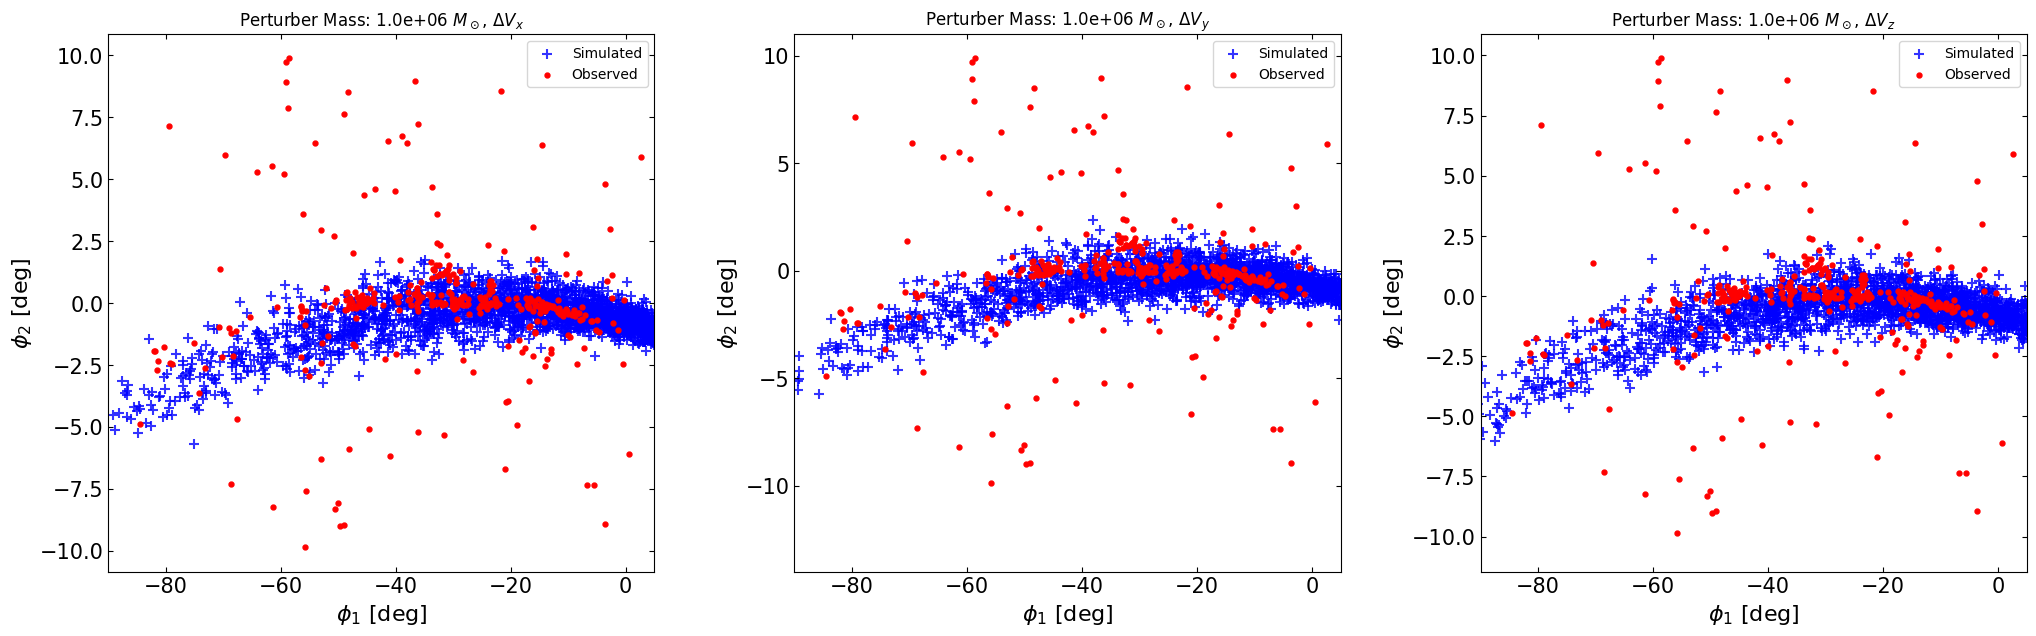

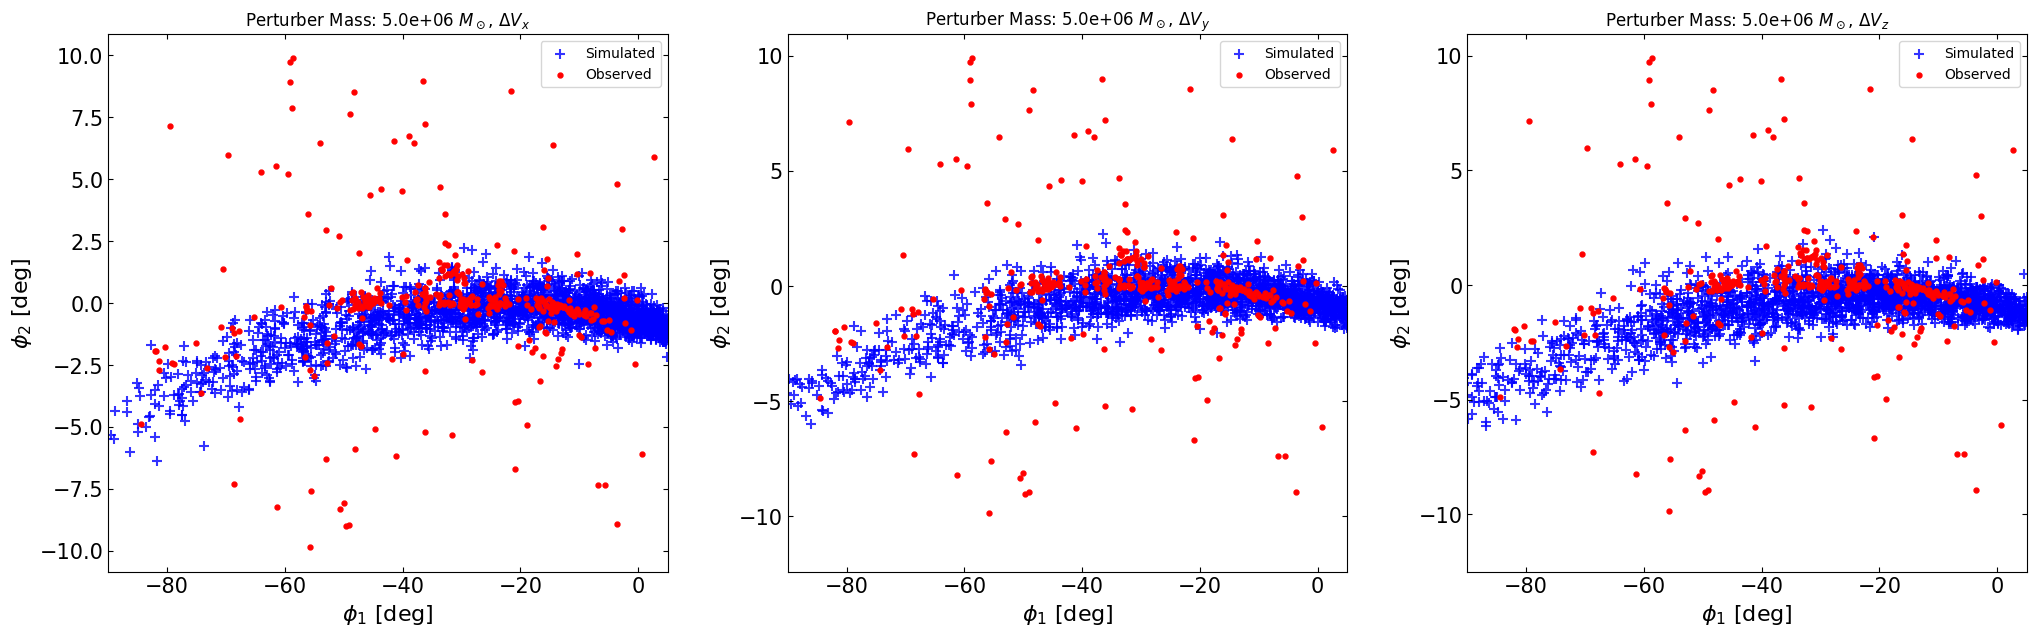

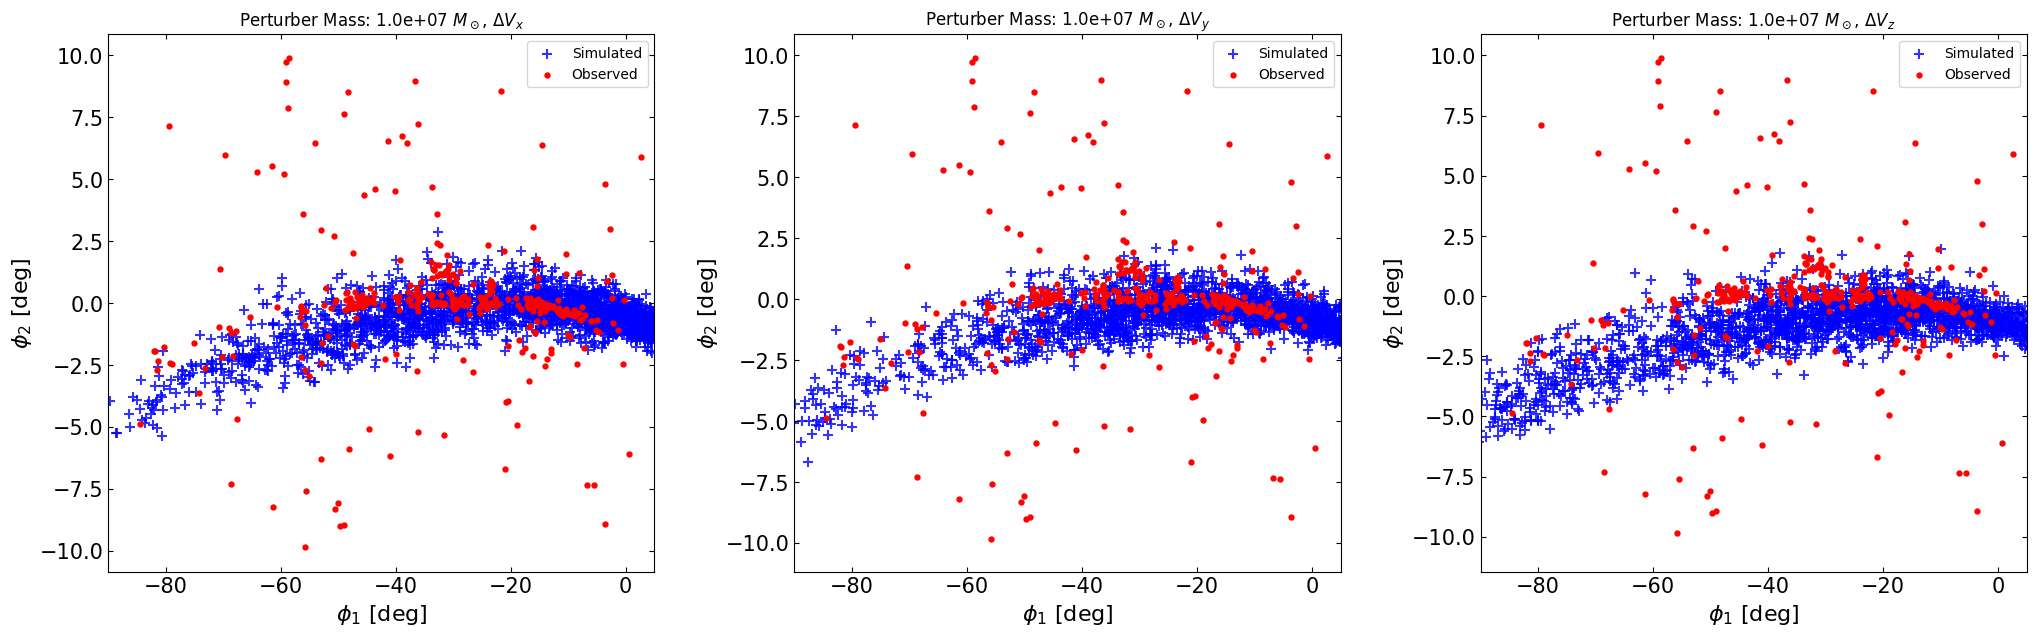

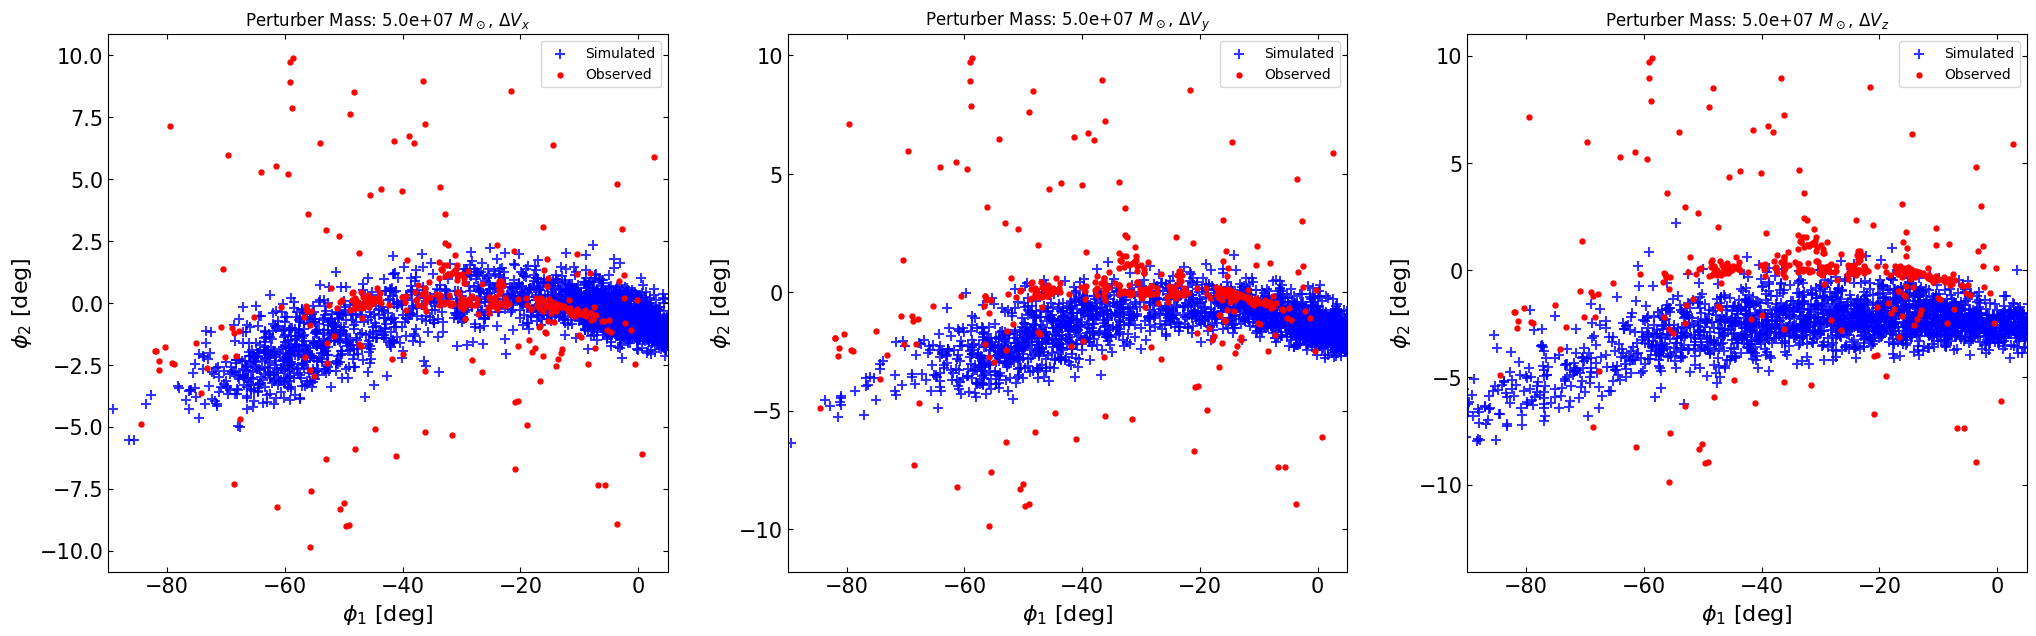

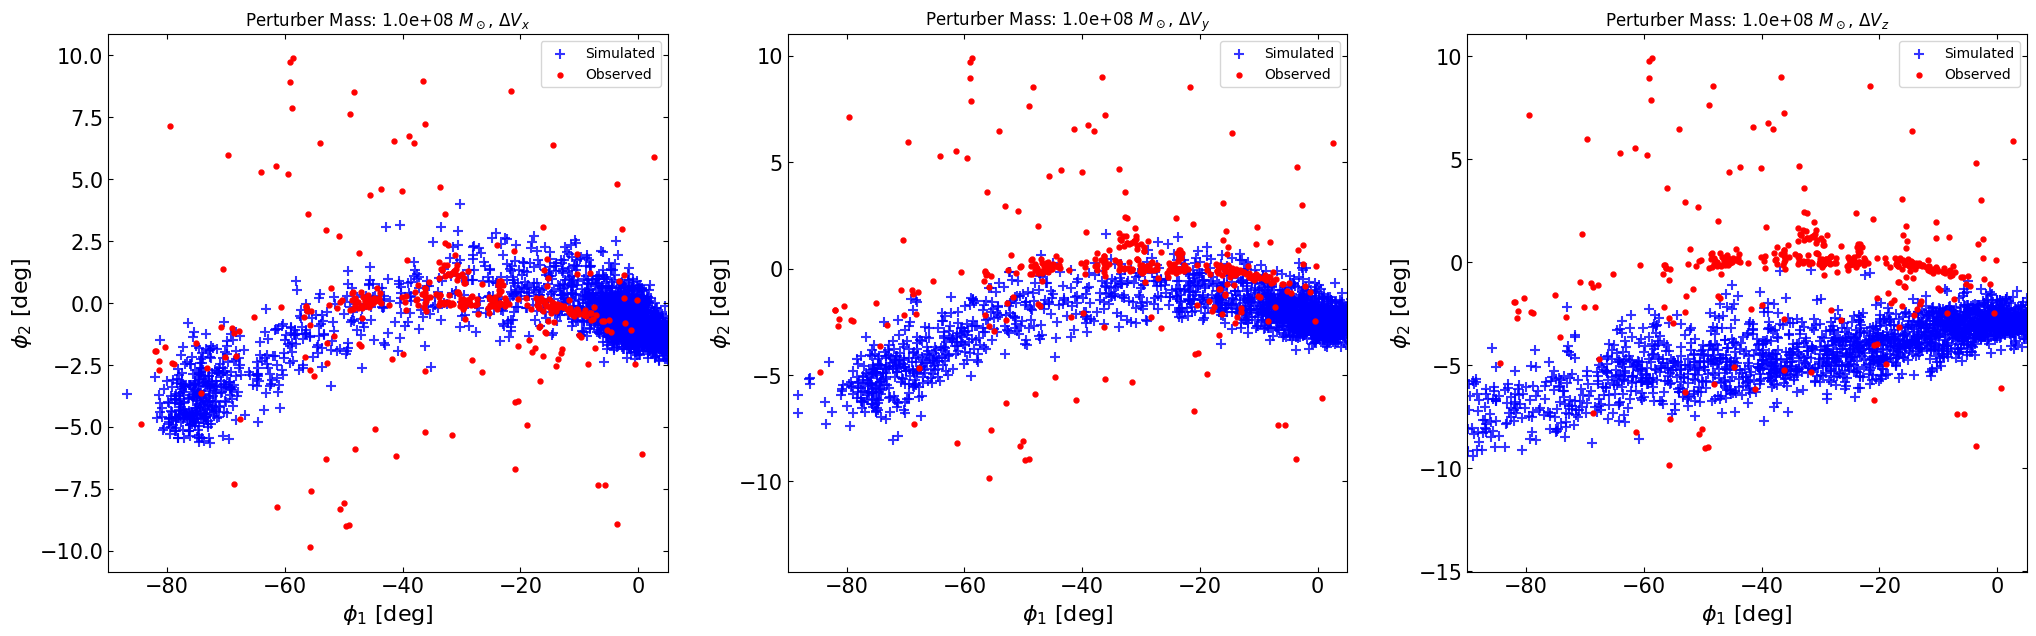

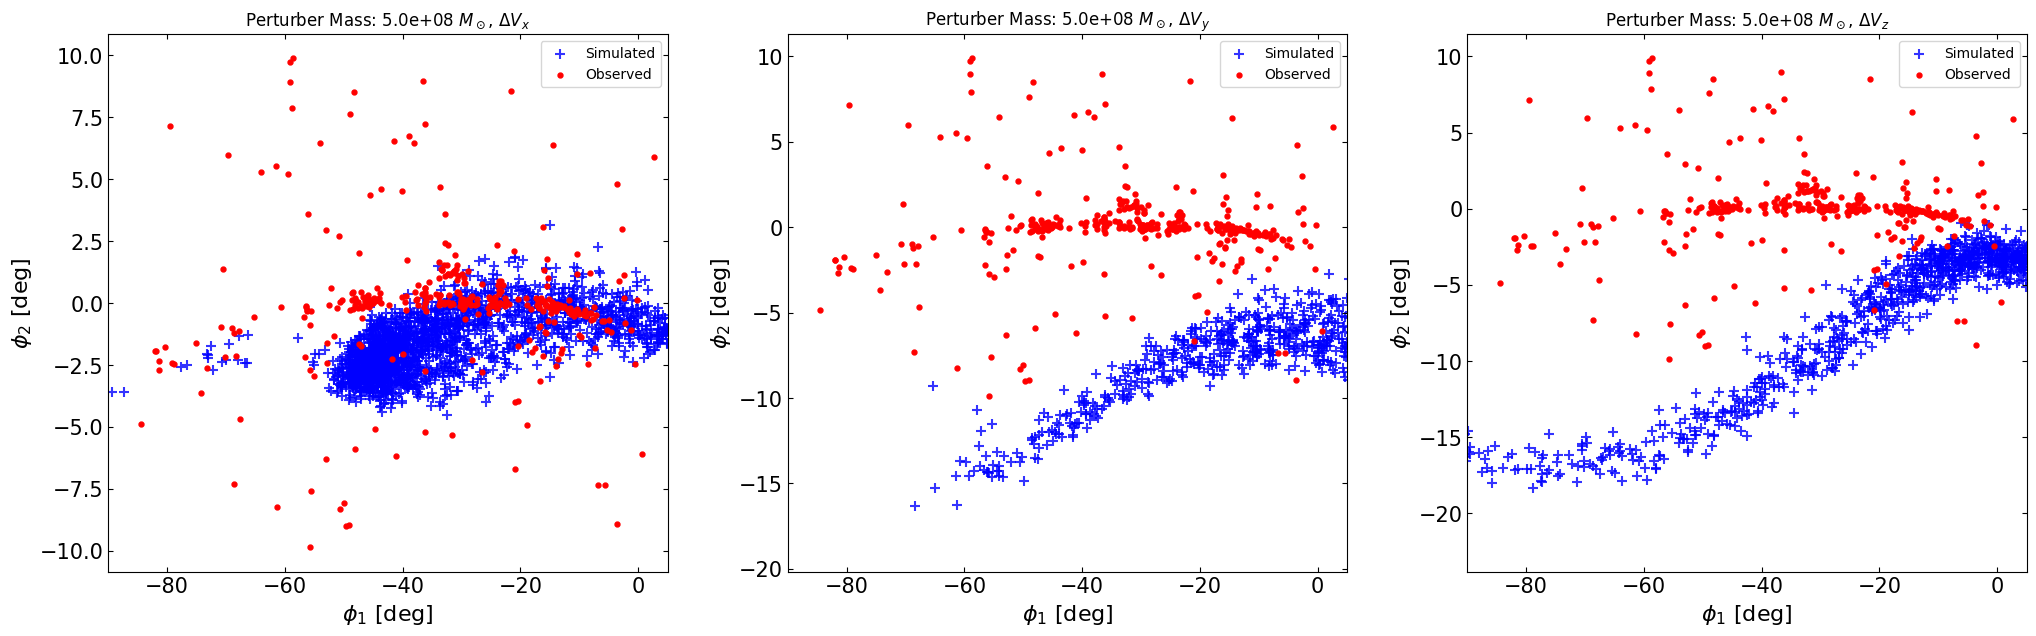

In [11]:
for pert_mass in p_mass:
    # Retrieve the stream and progenitor information for x, y, z
    stream_x = stream_data[pert_mass][0]
    prog_x = stream_data[pert_mass][1]
    
    stream_y = stream_data_dy[pert_mass][0]
    prog_y = stream_data_dy[pert_mass][1]
    
    stream_z = stream_data_dz[pert_mass][0]
    prog_z = stream_data_dz[pert_mass][1]
    
    # Convert to ICRS coordinates
    stream_icrs_x = stream_x.to_coord_frame(coord.ICRS())
    prog_icrs_x = prog_x.to_coord_frame(coord.ICRS())
    
    stream_icrs_y = stream_y.to_coord_frame(coord.ICRS())
    prog_icrs_y = prog_y.to_coord_frame(coord.ICRS())
    
    stream_icrs_z = stream_z.to_coord_frame(coord.ICRS())
    prog_icrs_z = prog_z.to_coord_frame(coord.ICRS())
    
    # Transform to GD1Koposov10 frame
    gd1_sim_x = stream_icrs_x.transform_to(gc.GD1Koposov10())
    gd1_sim_y = stream_icrs_y.transform_to(gc.GD1Koposov10())
    gd1_sim_z = stream_icrs_z.transform_to(gc.GD1Koposov10())
    
    # Create a figure with 3 subplots in a row
    fig, axs = plt.subplots(1, 3, figsize=(21, 7))
    
    x_range = (gd1_sim_x.phi1 >= -90 * u.deg) & (gd1_sim_x.phi1 <= 5 * u.deg)
    y_range = (gd1_sim_x.phi2 >= -10 * u.deg) & (gd1_sim_x.phi2 <= 10 * u.deg)
    # Plot for stream_x
    axs[0].tick_params(axis='both', which='both', direction='in', labelsize=15, right=True, top=True)
    axs[0].set_xlabel(r'$\phi_1$ [deg]', fontsize=16)
    axs[0].set_ylabel(r'$\phi_2$ [deg]', fontsize=16)
    axs[0].set_title(f'Perturber Mass: {pert_mass:.1e} $M_\odot$, $\Delta V_x$')
    axs[0].scatter(gd1_sim_x.phi1[x_range], gd1_sim_x.phi2[x_range], marker='+', s=50, color='blue', alpha=0.8, label='Simulated')
    axs[0].scatter(phi1, phi2, color='red', marker='.', s=50, cmap='tab20b', label='Observed')
    # axs[0].set_ylim(-10.,10.)
    axs[0].set_xlim(-90, 5.)
    axs[0].legend()
    axs[0].grid(False)
    
    # Plot for stream_y
    axs[1].tick_params(axis='both', which='both', direction='in', labelsize=15, right=True, top=True)
    axs[1].set_xlabel(r'$\phi_1$ [deg]', fontsize=16)
    axs[1].set_ylabel(r'$\phi_2$ [deg]', fontsize=16)
    axs[1].set_title(f'Perturber Mass: {pert_mass:.1e} $M_\odot$, $\Delta V_y$')
    axs[1].scatter(gd1_sim_y.phi1[x_range], gd1_sim_y.phi2[x_range], marker='+', s=50, color='blue', alpha=0.8, label='Simulated')
    axs[1].scatter(phi1, phi2, color='red', marker='.', s=50, cmap='tab20b', label='Observed')
    # axs[1].set_ylim(-10.,10.)
    axs[1].set_xlim(-90, 5.)
    axs[1].legend()
    axs[1].grid(False)
    
    # Plot for stream_z
    axs[2].tick_params(axis='both', which='both', direction='in', labelsize=15, right=True, top=True)
    axs[2].set_xlabel(r'$\phi_1$ [deg]', fontsize=16)
    axs[2].set_ylabel(r'$\phi_2$ [deg]', fontsize=16)
    axs[2].set_title(f'Perturber Mass: {pert_mass:.1e} $M_\odot$, $\Delta V_z$')
    axs[2].scatter(gd1_sim_z.phi1[x_range], gd1_sim_z.phi2[x_range], marker='+', s=50, color='blue', alpha=0.8, label='Simulated')
    axs[2].scatter(phi1, phi2, color='red', marker='.', s=50, cmap='tab20b', label='Observed')
    # axs[2].set_ylim(-10.,10.)
    axs[2].set_xlim(-90, 5.)
    axs[2].legend()
    axs[2].grid(False)
    
    fig.tight_layout(pad=3.0)
    plt.savefig(f'phi1_phi2_plots/GD1_sim_dat_with_perturber_comp_pot_{pert_mass:.1e}.png', dpi = 300)
    plt.show()
    plt.close()


In [13]:
# # Get the type of gd1_sim_y.phi1
# phi1_type = type(gd1_sim_y.phi1)

# # Index the values that fall between -80 and 0
# filtered_phi1 = gd1_sim_y.phi1[(gd1_sim_y.phi1 >= -80 * u.deg) & (gd1_sim_y.phi1 <= 0 * u.deg)]

 # # Display the filtered values
 # filtered_phi1

In [14]:
# from astropy.coordinates import SkyCoord

# import astropy.units as u

# # Calculate the median of phi_1 and phi_2
# median_phi1 = df_desi['phi_1'].median() * u.deg
# median_phi2 = df_desi['phi_2'].median() * u.deg

# # Assume a distance for the conversion, for example, the median distance from the observed data
# median_distance = df_desi['dist'].median() * u.kpc

# # Create a SkyCoord object for the median values
# median_coord = SkyCoord(phi1=median_phi1, phi2=median_phi2, distance=median_distance, frame=gc.GD1Koposov10)

# # Convert to Cartesian coordinates
# x = median_coord.cartesian.x
# y = median_coord.cartesian.y
# z = median_coord.cartesian.z

# print(f"Median Cartesian Coordinates: x = {x}, y = {y}, z = {z}")

<>:27: SyntaxWarning: invalid escape sequence '\o'
<>:39: SyntaxWarning: invalid escape sequence '\o'
<>:51: SyntaxWarning: invalid escape sequence '\o'
<>:27: SyntaxWarning: invalid escape sequence '\o'
<>:39: SyntaxWarning: invalid escape sequence '\o'
<>:51: SyntaxWarning: invalid escape sequence '\o'
/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/T/ipykernel_41623/245579360.py:27: SyntaxWarning: invalid escape sequence '\o'
  axs[0].set_title(f'Perturber Mass: {pert_mass:.1e} $M_\odot$, $\Delta V_x$')
/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/T/ipykernel_41623/245579360.py:39: SyntaxWarning: invalid escape sequence '\o'
  axs[1].set_title(f'Perturber Mass: {pert_mass:.1e} $M_\odot$, $\Delta V_y$')
/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/T/ipykernel_41623/245579360.py:51: SyntaxWarning: invalid escape sequence '\o'
  axs[2].set_title(f'Perturber Mass: {pert_mass:.1e} $M_\odot$, $\Delta V_z$')


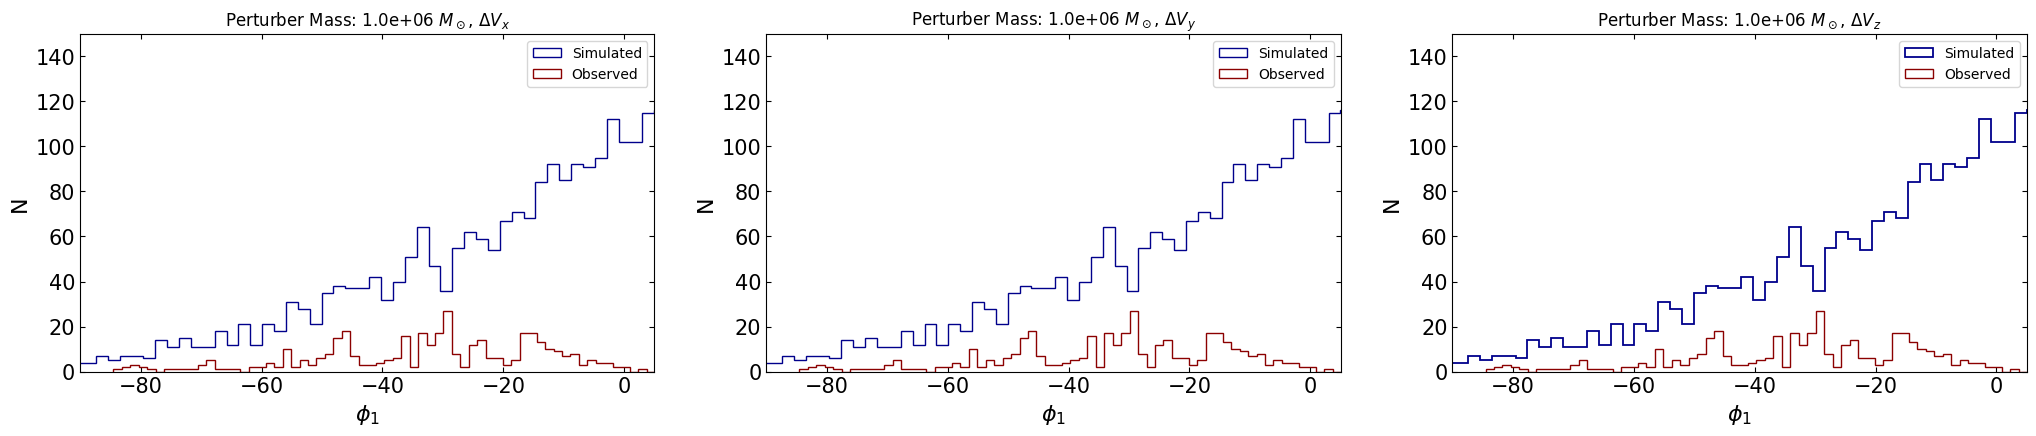

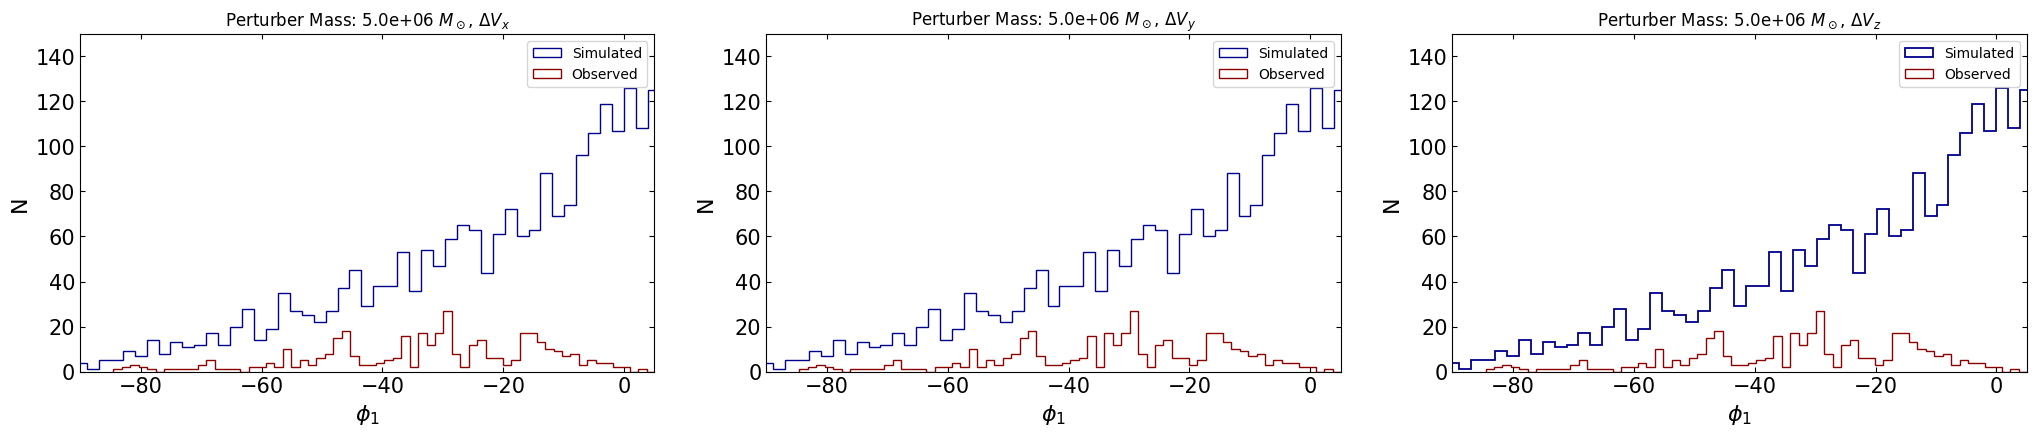

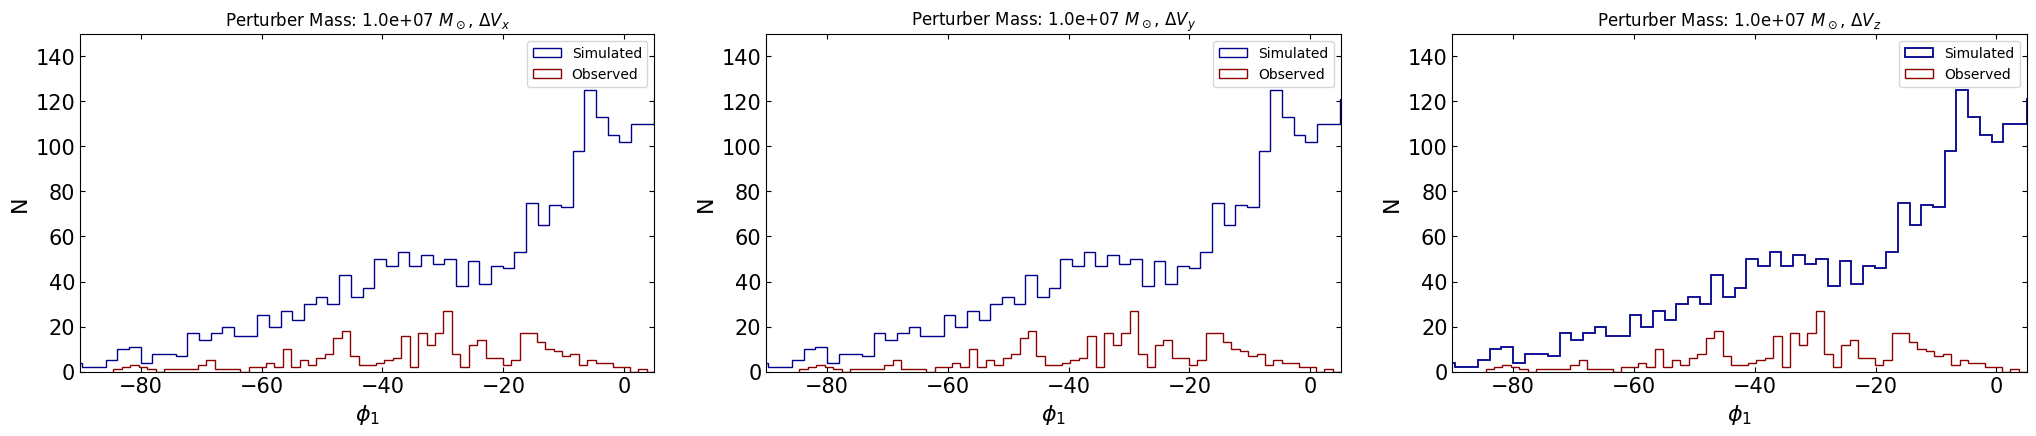

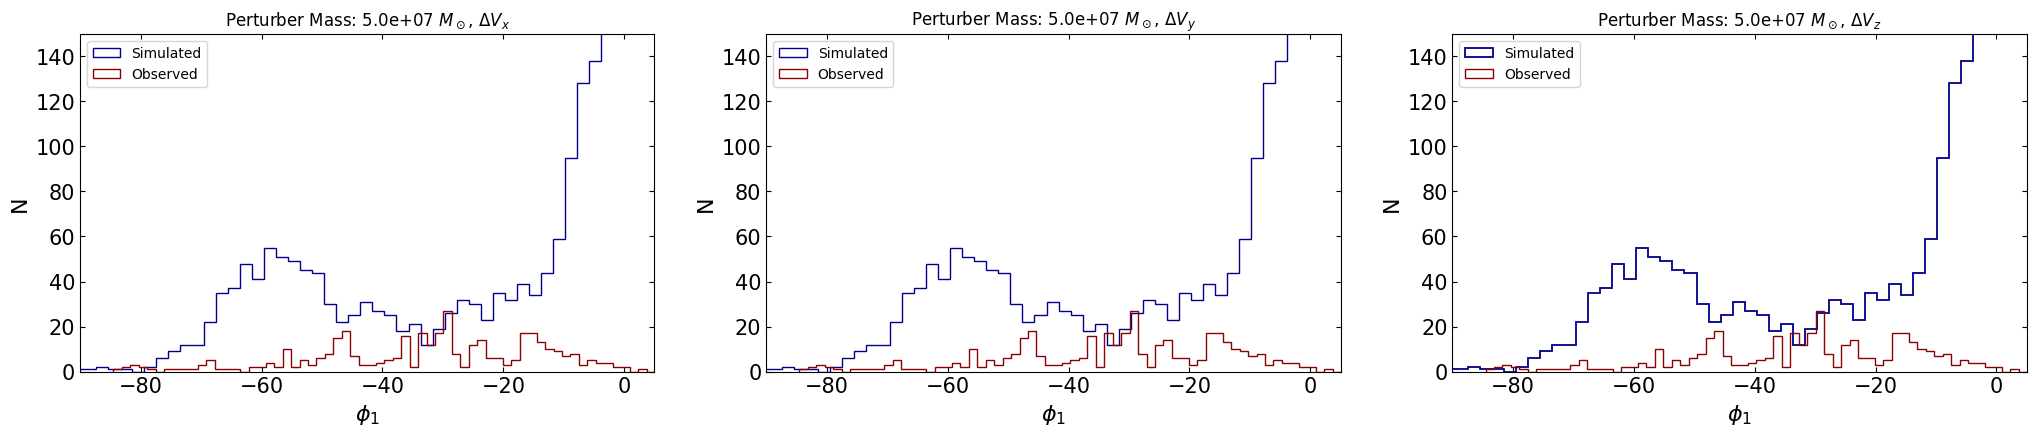

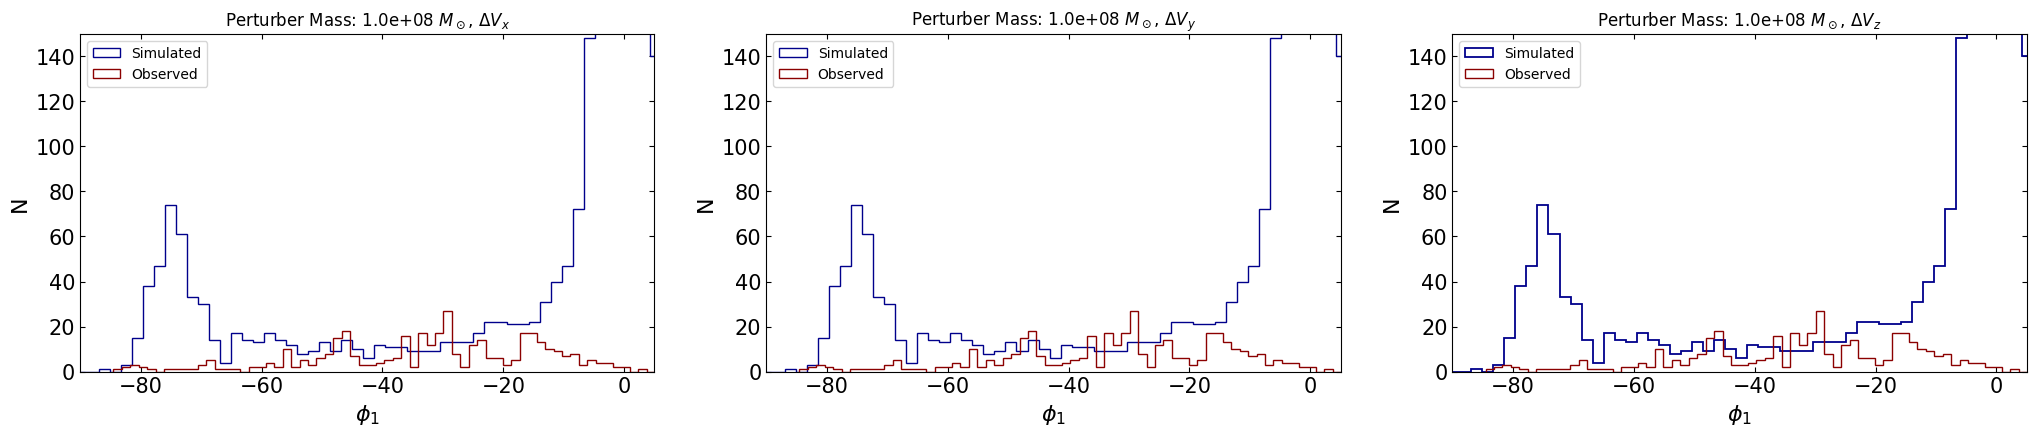

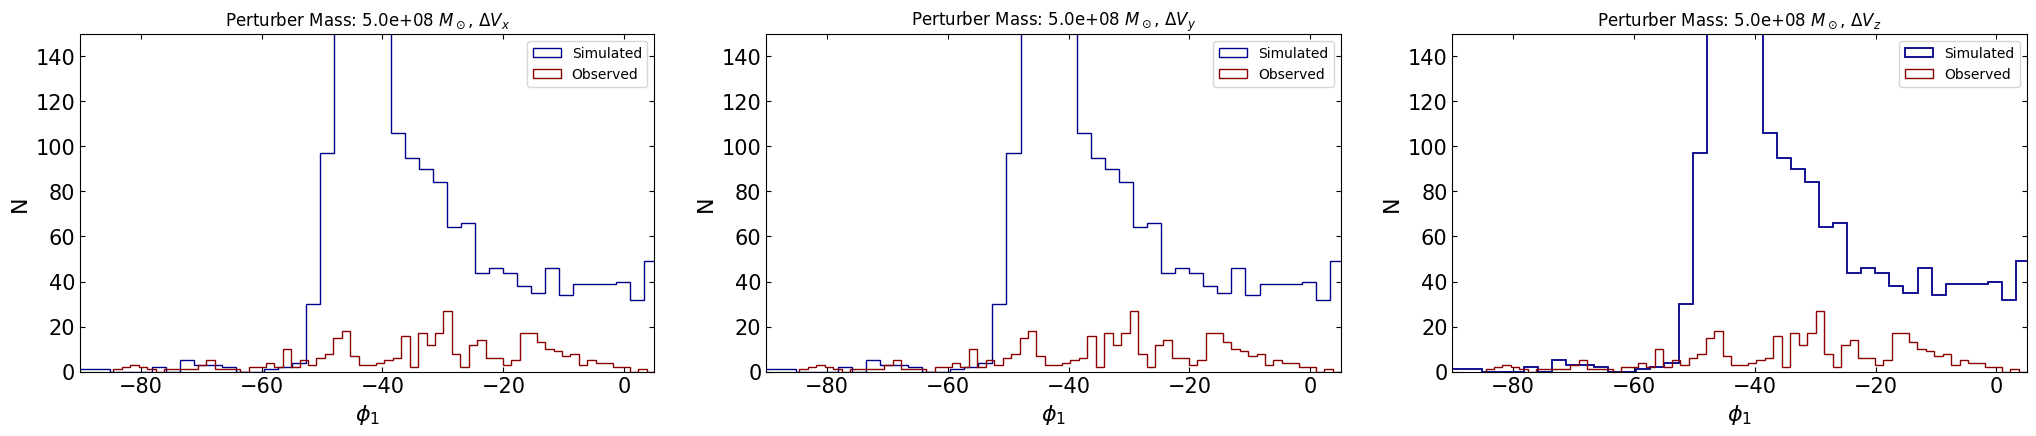

In [15]:

phi1 = df_desi['phi_1'] * u.rad
phi2 = df_desi['phi_2'] * u.rad

for pert_mass in p_mass:
    # Retrieve the stream and progenitor information for x, y, z
    stream_x = stream_data[pert_mass][0]
    stream_y = stream_data_dy[pert_mass][0]
    stream_z = stream_data_dz[pert_mass][0]
    
    # Convert to ICRS coordinates
    stream_icrs_x = stream_x.to_coord_frame(coord.ICRS())
    stream_icrs_y = stream_y.to_coord_frame(coord.ICRS())
    stream_icrs_z = stream_z.to_coord_frame(coord.ICRS())
    
    # Transform to GD1Koposov10 frame
    gd1_sim_x = stream_icrs_x.transform_to(gc.GD1Koposov10())
    gd1_sim_y = stream_icrs_y.transform_to(gc.GD1Koposov10())
    gd1_sim_z = stream_icrs_z.transform_to(gc.GD1Koposov10())
    
    # Create a figure for each perturber mass
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    
    # Plot for stream_x
    axs[0].tick_params(axis='both', which='both', direction='in', labelsize=15, right=True, top=True)
    axs[0].set_xlabel(r'$\phi_1$', fontsize=16)
    axs[0].set_ylabel('N', fontsize=16)
    axs[0].set_title(f'Perturber Mass: {pert_mass:.1e} $M_\odot$, $\Delta V_x$')
    axs[0].hist(gd1_sim_x.phi1, bins=100, histtype='step', color='darkblue', label='Simulated')
    axs[0].hist(phi1, bins=100, histtype='step', color='darkred', label='Observed')
    axs[0].set_ylim(0, 150)
    axs[0].set_xlim(-90, 5.)
    axs[0].legend()
    axs[0].grid(False)
    
    # Plot for stream_y
    axs[1].tick_params(axis='both', which='both', direction='in', labelsize=15, right=True, top=True)
    axs[1].set_xlabel(r'$\phi_1$', fontsize=16)
    axs[1].set_ylabel('N', fontsize=16)
    axs[1].set_title(f'Perturber Mass: {pert_mass:.1e} $M_\odot$, $\Delta V_y$')
    axs[1].hist(gd1_sim_x.phi1, bins=100, histtype='step', color='darkblue', label='Simulated')
    axs[1].hist(phi1, bins=100, histtype='step', color='darkred', label='Observed')
    axs[1].set_ylim(0, 150)
    axs[1].set_xlim(-90, 5.)
    axs[1].legend()
    axs[1].grid(False)
    
    # Plot for stream_z
    axs[2].tick_params(axis='both', which='both', direction='in', labelsize=15, right=True, top=True)
    axs[2].set_xlabel(r'$\phi_1$', fontsize=16)
    axs[2].set_ylabel('N', fontsize=16)
    axs[2].set_title(f'Perturber Mass: {pert_mass:.1e} $M_\odot$, $\Delta V_z$')
    axs[2].hist(gd1_sim_x.phi1, bins=100, histtype='step', color='darkblue', linewidth = 1.3, label='Simulated')
    axs[2].hist(phi1, bins=100, histtype='step', color='darkred', label='Observed')
    axs[2].set_ylim(0, 150)
    axs[2].set_xlim(-90, 5.)
    axs[2].legend()
    axs[2].grid(False)
    
    fig.tight_layout(pad=3.0)
    plt.savefig(f'phi1_phi2_plots/GD1_sim_dat_with_perturber_comp_pot_{pert_mass:.1e}.png')
    plt.show()
    plt.close()
